In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [539]:
df = pd.read_csv("../../data/csv_files/df_ph1.csv")

In [541]:
df.shape

(7748, 10)

In [543]:
df['dt'] = pd.to_datetime(df['dt'])

In [545]:
stations = list(df.columns)
stations.remove('dt')

In [547]:
start_array = []
end_array = []
index = 3
start_na = True
print(stations[index])

for _, row in df.iterrows():
    if pd.isna(row[stations[index]]) and start_na:
        start_na = False
        start_array.append(row['dt'])
    elif not pd.isna(row[stations[index]]) and not start_na:
        start_na = True
        end_array.append(row['dt'])

FSB_126


In [549]:
print(len(start_array), len(end_array))

85 85


In [551]:
start_end = {}
for start, end in zip(start_array, end_array):
    start_end[start] = end
print(len(start_end))

85


In [553]:
length = {}
for start, end in start_end.items():
    length[(start, end)] = pd.to_datetime(end) - pd.to_datetime(start)
print(len(length))

85


In [555]:
na_data = {}
for key, duration in length.items():
    if duration > pd.Timedelta(days=1):
        na_data[key] = duration
print(len(na_data))
na_data

10


{(Timestamp('2023-07-28 08:00:00'),
  Timestamp('2023-07-31 13:00:00')): Timedelta('3 days 05:00:00'),
 (Timestamp('2023-07-31 14:00:00'),
  Timestamp('2023-08-03 22:00:00')): Timedelta('3 days 08:00:00'),
 (Timestamp('2023-08-04 07:00:00'),
  Timestamp('2023-08-08 04:00:00')): Timedelta('3 days 21:00:00'),
 (Timestamp('2023-08-09 11:00:00'),
  Timestamp('2023-08-13 16:00:00')): Timedelta('4 days 05:00:00'),
 (Timestamp('2023-08-13 20:00:00'),
  Timestamp('2023-08-19 05:00:00')): Timedelta('5 days 09:00:00'),
 (Timestamp('2023-08-19 09:00:00'),
  Timestamp('2023-08-21 19:00:00')): Timedelta('2 days 10:00:00'),
 (Timestamp('2023-08-23 20:00:00'),
  Timestamp('2023-08-28 16:00:00')): Timedelta('4 days 20:00:00'),
 (Timestamp('2023-08-28 17:00:00'),
  Timestamp('2023-08-31 07:00:00')): Timedelta('2 days 14:00:00'),
 (Timestamp('2023-08-31 22:00:00'),
  Timestamp('2023-10-18 14:45:00')): Timedelta('47 days 16:45:00'),
 (Timestamp('2024-01-01 01:00:00'),
  Timestamp('2024-01-24 14:06:00')):

In [557]:
new_df = df[df['dt'] >= "2024-01-24 17:00:00"]
print(new_df.shape)

(3390, 10)


In [559]:
new_df.isna().sum()

dt             0
FEX_004       21
FSB_095DR     21
FSB_078       21
FSB_126       32
FSB_130D      21
FPZ_06A       22
FSB_079       21
FPZ_04A       21
FSB_097D     186
dtype: int64

In [561]:
df_interpolate = new_df.copy()
for col in stations:
    df_interpolate[col] = df_interpolate[col].interpolate()

In [563]:
test_df = df_interpolate.drop(columns = ["dt"])
test_df.shape

(3390, 9)

In [565]:
test_df = test_df.fillna(5.243915)

In [567]:
test_df.isna().sum()

FEX_004      0
FSB_095DR    0
FSB_078      0
FSB_126      0
FSB_130D     0
FPZ_06A      0
FSB_079      0
FPZ_04A      0
FSB_097D     0
dtype: int64

In [569]:
# Flattening the dataframe
flat_array = test_df.values.flatten()
len(flat_array)

30510

In [571]:
# reshaping to 90 columns
reshaped_array = flat_array.reshape(-1,90)

In [573]:
new_df = pd.DataFrame(reshaped_array)

In [575]:
new_df.shape

(339, 90)

In [577]:
scaler = StandardScaler()
normalized_df = scaler.fit_transform(new_df)

In [579]:
tensor_data = torch.tensor(normalized_df, dtype=torch.float32)

dataset = TensorDataset(tensor_data, tensor_data)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [672]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 60),  
            nn.ReLU(),
            nn.Linear(60, 45),        
            nn.ReLU(),
            nn.Linear(45, 30),        
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 45),         
            nn.ReLU(),
            nn.Linear(45, 60),        
            nn.ReLU(),
            nn.Linear(60, input_dim), 
            nn.Sigmoid()               
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [674]:
input_dim = normalized_df.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [676]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.1500
Epoch [2/100], Loss: 1.3185
Epoch [3/100], Loss: 1.2859
Epoch [4/100], Loss: 1.0032
Epoch [5/100], Loss: 1.0743
Epoch [6/100], Loss: 0.9461
Epoch [7/100], Loss: 0.8225
Epoch [8/100], Loss: 0.8133
Epoch [9/100], Loss: 0.7024
Epoch [10/100], Loss: 0.7032
Epoch [11/100], Loss: 0.6158
Epoch [12/100], Loss: 0.6657
Epoch [13/100], Loss: 0.5553
Epoch [14/100], Loss: 0.8734
Epoch [15/100], Loss: 0.7262
Epoch [16/100], Loss: 0.5220
Epoch [17/100], Loss: 0.5538
Epoch [18/100], Loss: 0.6499
Epoch [19/100], Loss: 0.5992
Epoch [20/100], Loss: 0.7146
Epoch [21/100], Loss: 0.4766
Epoch [22/100], Loss: 0.4934
Epoch [23/100], Loss: 0.6290
Epoch [24/100], Loss: 0.6162
Epoch [25/100], Loss: 0.6561
Epoch [26/100], Loss: 0.7314
Epoch [27/100], Loss: 0.7605
Epoch [28/100], Loss: 0.5707
Epoch [29/100], Loss: 0.6420
Epoch [30/100], Loss: 0.8045
Epoch [31/100], Loss: 0.6521
Epoch [32/100], Loss: 0.5595
Epoch [33/100], Loss: 0.5842
Epoch [34/100], Loss: 0.6911
Epoch [35/100], Loss: 0

In [677]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(tensor_data)
    reconstruction_error = torch.mean((tensor_data - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))

339


In [680]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

1.5728065371513367

In [682]:
anomalies = reconstruction_error > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 25


In [684]:
reconstructed_data

tensor([[1.2303e-09, 1.2026e-16, 1.3246e-05,  ..., 3.5657e-18, 1.1974e-08,
         2.3675e-05],
        [1.0541e-09, 8.6839e-17, 1.1039e-05,  ..., 1.5489e-18, 1.3308e-08,
         2.1325e-05],
        [8.4701e-10, 5.0825e-17, 1.4282e-05,  ..., 1.1700e-18, 9.2951e-09,
         1.8942e-05],
        ...,
        [9.9847e-01, 1.0000e+00, 5.4561e-09,  ..., 9.9988e-01, 9.6180e-09,
         9.9997e-01],
        [9.9869e-01, 1.0000e+00, 3.9249e-09,  ..., 9.9991e-01, 5.6866e-09,
         9.9998e-01],
        [9.9872e-01, 1.0000e+00, 3.6672e-09,  ..., 9.9991e-01, 5.6201e-09,
         9.9998e-01]])

In [686]:
numpy_array = reconstructed_data.numpy()
numpy_array.shape

(339, 90)

In [688]:
predicted_df = pd.DataFrame(numpy_array)
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.230266e-09,1.202586e-16,0.000013,5.028011e-15,2.234567e-07,0.414031,1.370083e-17,8.901619e-12,0.000024,2.302264e-11,...,0.000012,1.014785e-11,9.635597e-16,0.000030,8.727975e-17,9.827209e-10,0.421696,3.565674e-18,1.197361e-08,0.000024
1,1.054054e-09,8.683872e-17,0.000011,3.545781e-15,1.700597e-07,0.318049,6.324261e-18,9.169186e-12,0.000021,1.763397e-11,...,0.000012,7.779383e-12,6.994160e-16,0.000025,5.790247e-17,6.708084e-10,0.329385,1.548887e-18,1.330817e-08,0.000021
2,8.470146e-10,5.082503e-17,0.000014,2.178434e-15,1.187357e-07,0.405581,4.765506e-18,5.856114e-12,0.000017,1.388890e-11,...,0.000010,6.445486e-12,4.719667e-16,0.000031,3.185236e-17,4.292199e-10,0.418432,1.170000e-18,9.295067e-09,0.000019
3,7.473424e-10,3.854783e-17,0.000013,1.515123e-15,8.240900e-08,0.257907,1.806596e-18,7.298568e-12,0.000016,1.109224e-11,...,0.000010,5.047487e-12,3.489622e-16,0.000029,1.971009e-17,2.536388e-10,0.270934,3.696020e-19,1.254489e-08,0.000017
4,7.385116e-10,3.732010e-17,0.000014,1.465436e-15,7.947842e-08,0.259590,1.748763e-18,7.189458e-12,0.000015,1.097548e-11,...,0.000010,5.007996e-12,3.409631e-16,0.000030,1.875342e-17,2.418762e-10,0.272442,3.535698e-19,1.243870e-08,0.000017


In [690]:
test_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,4.200342,4.336478,4.332603,4.391724,4.334914,5.243915,7.767760,7.494180,3.997277
4359,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174


In [692]:
reversed_df = pd.DataFrame(scaler.inverse_transform(predicted_df), columns=predicted_df.columns)
reversed_df

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,4.295360,4.414905,4.366243,4.437210,4.413437,5.254160,7.630953,7.5125,4.083997,4.295420,...,4.084414,4.295856,4.415288,4.366303,4.437558,4.414546,5.256997,7.631305,7.511964,4.084491
1,4.295360,4.414905,4.366243,4.437210,4.413437,5.237490,7.630953,7.5125,4.083997,4.295420,...,4.084414,4.295856,4.415288,4.366302,4.437558,4.414546,5.240867,7.631305,7.511964,4.084491
2,4.295360,4.414905,4.366243,4.437210,4.413437,5.252693,7.630953,7.5125,4.083997,4.295420,...,4.084414,4.295856,4.415288,4.366303,4.437558,4.414546,5.256427,7.631305,7.511964,4.084491
3,4.295360,4.414905,4.366243,4.437210,4.413437,5.227044,7.630953,7.5125,4.083997,4.295420,...,4.084414,4.295856,4.415288,4.366303,4.437558,4.414546,5.230653,7.631305,7.511964,4.084491
4,4.295360,4.414905,4.366243,4.437210,4.413437,5.227336,7.630953,7.5125,4.083997,4.295420,...,4.084414,4.295856,4.415288,4.366303,4.437558,4.414546,5.230917,7.631305,7.511964,4.084491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,4.348660,4.463537,4.366243,4.463249,4.476644,5.182250,7.731146,7.5125,4.140097,4.348700,...,4.140468,4.349135,4.463882,4.366302,4.463590,4.479648,5.183310,7.732039,7.511964,4.140546
335,4.348665,4.463537,4.366243,4.463249,4.476644,5.182250,7.731148,7.5125,4.140097,4.348706,...,4.140468,4.349139,4.463882,4.366302,4.463590,4.479648,5.183310,7.732040,7.511964,4.140546
336,4.348659,4.463537,4.366243,4.463249,4.476644,5.182250,7.731148,7.5125,4.140097,4.348701,...,4.140468,4.349131,4.463882,4.366302,4.463590,4.479648,5.183310,7.732040,7.511964,4.140545
337,4.348671,4.463537,4.366243,4.463249,4.476644,5.182250,7.731152,7.5125,4.140097,4.348717,...,4.140468,4.349143,4.463882,4.366302,4.463590,4.479648,5.183310,7.732043,7.511964,4.140546


In [694]:
flat_array = reversed_df.values.flatten()
len(flat_array)

30510

In [696]:
reshaped_array = flat_array.reshape(-1,9)

In [698]:
predicted_df = pd.DataFrame(reshaped_array)
predicted_df.shape

(3390, 9)

In [700]:
index_station = {}
for index, station in enumerate(stations):
    index_station[index] = station

index_station


{0: 'FEX_004',
 1: 'FSB_095DR',
 2: 'FSB_078',
 3: 'FSB_126',
 4: 'FSB_130D',
 5: 'FPZ_06A',
 6: 'FSB_079',
 7: 'FPZ_04A',
 8: 'FSB_097D'}

In [702]:
predicted_df.head()

,0,1,2,3,4,5,6,7,8
0,4.295360,4.414905,4.366243,4.437210,4.413437,5.254160,7.630953,7.512500,4.083997
1,4.295420,4.414919,4.366232,4.437243,4.413604,5.243221,7.631060,7.512359,4.084045
2,4.295499,4.414969,4.366528,4.437289,4.413696,5.252863,7.631057,7.514640,4.084107
3,4.295577,4.414983,4.366298,4.437247,4.414291,5.254735,7.631104,7.513200,4.084157
4,4.295586,4.415038,4.366475,4.437316,4.414574,5.259169,7.631253,7.512595,4.084195


In [704]:
predicted_df.rename(columns=index_station, inplace=True)

In [706]:
predicted_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,4.295360,4.414905,4.366243,4.437210,4.413437,5.254160,7.630953,7.512500,4.083997
1,4.295420,4.414919,4.366232,4.437243,4.413604,5.243221,7.631060,7.512359,4.084045
2,4.295499,4.414969,4.366528,4.437289,4.413696,5.252863,7.631057,7.514640,4.084107
3,4.295577,4.414983,4.366298,4.437247,4.414291,5.254735,7.631104,7.513200,4.084157
4,4.295586,4.415038,4.366475,4.437316,4.414574,5.259169,7.631253,7.512595,4.084195


In [708]:
test_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,4.200342,4.336478,4.332603,4.391724,4.334914,5.243915,7.767760,7.494180,3.997277
4359,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174


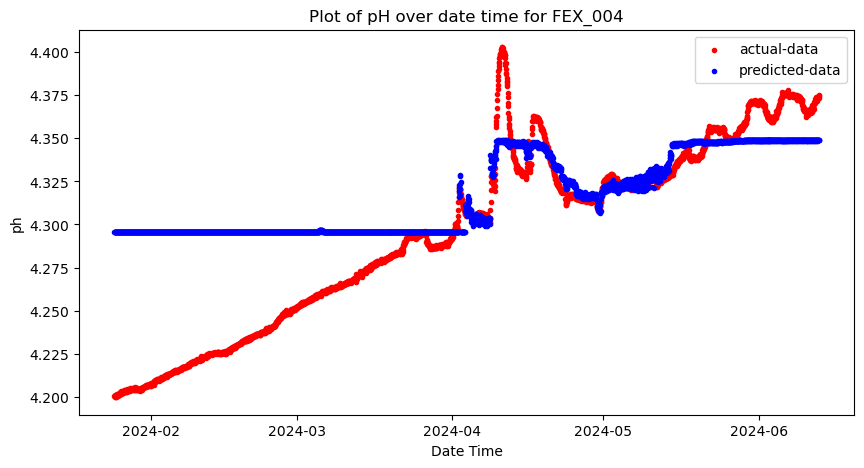

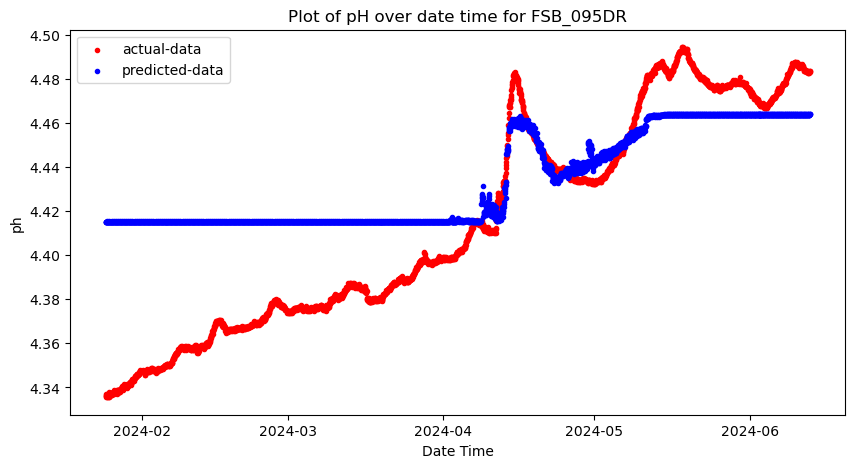

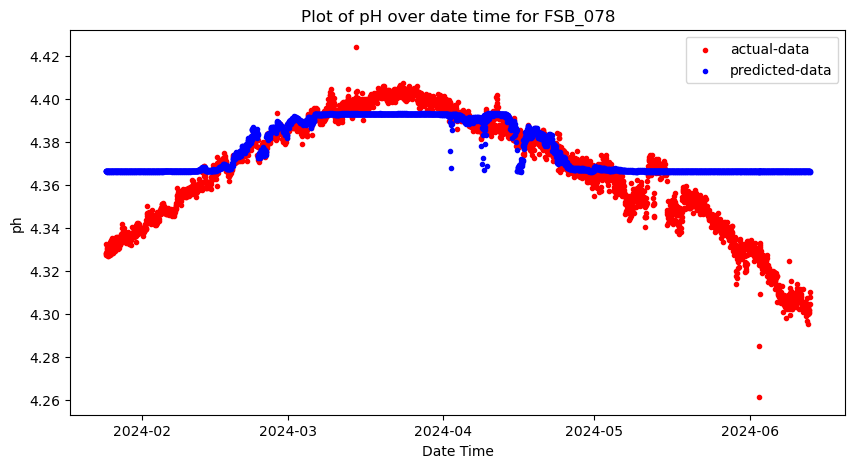

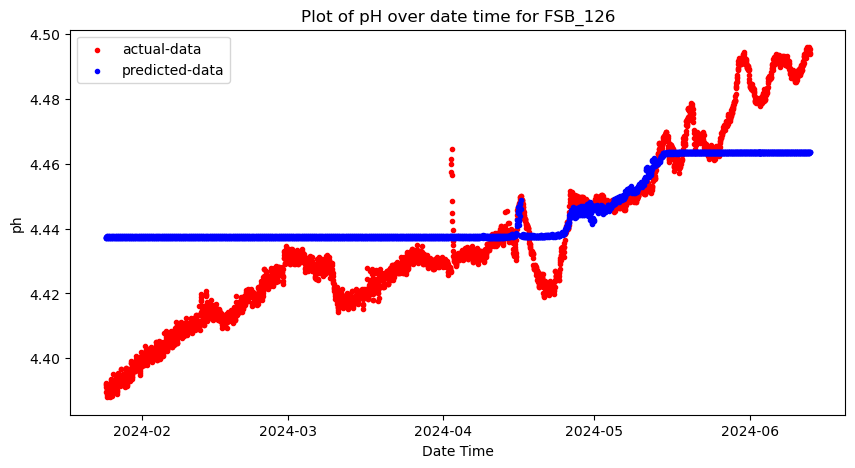

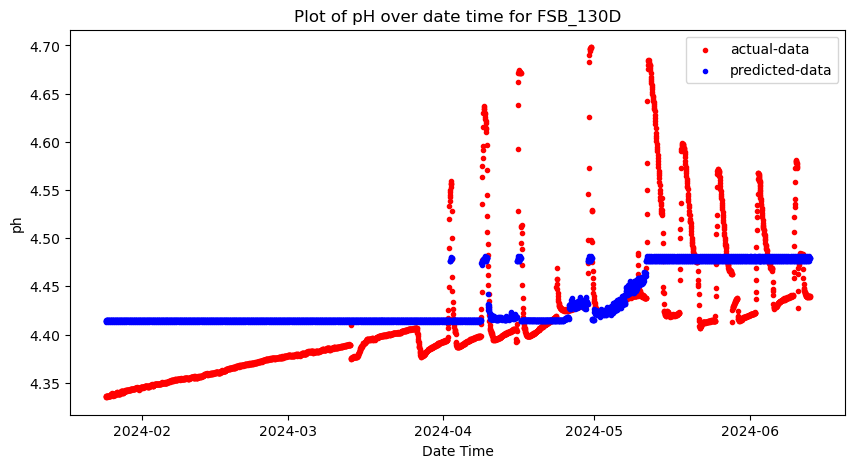

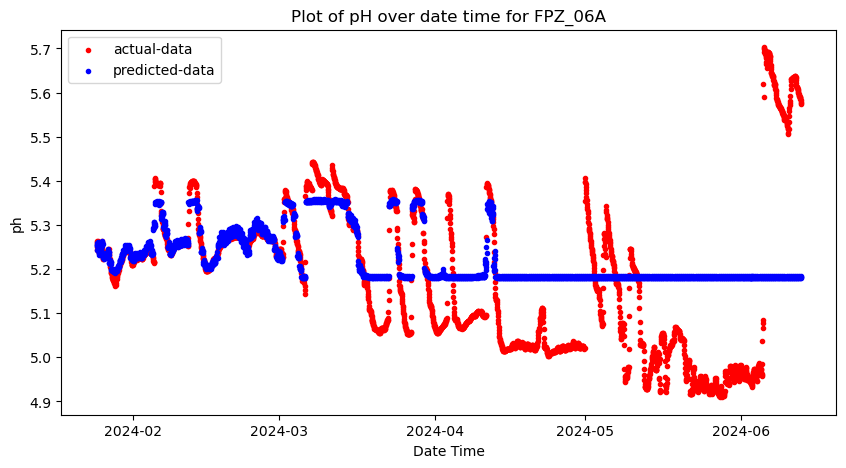

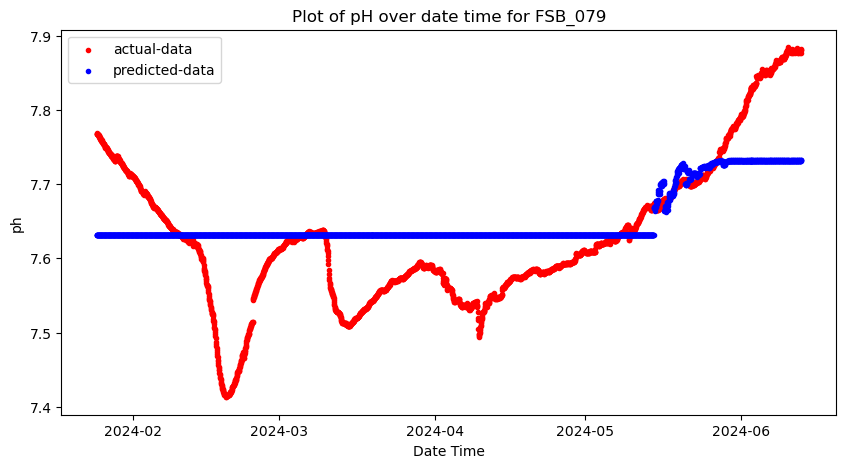

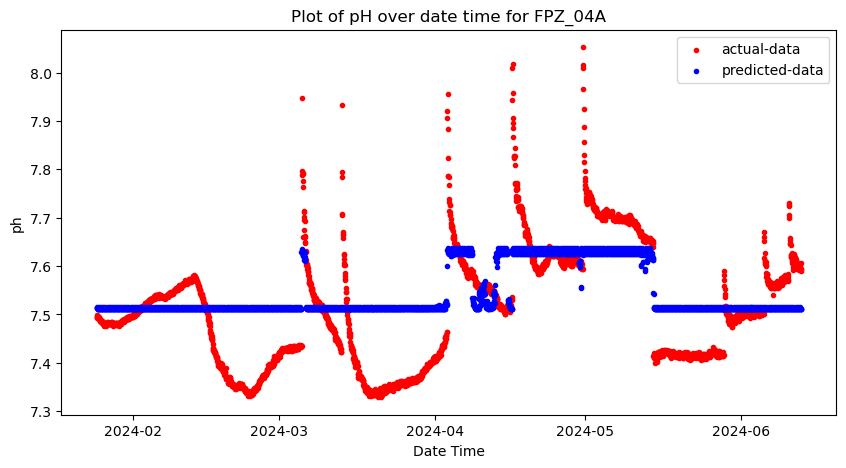

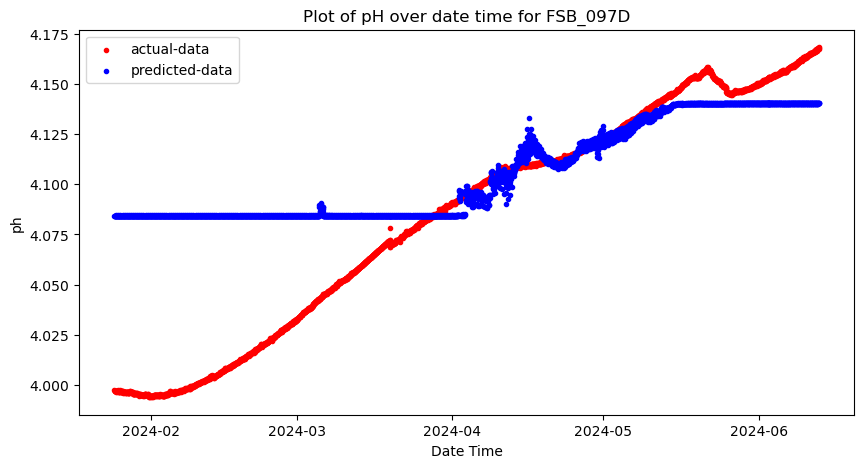

In [710]:
for index,station in enumerate(stations):
    
    plt.figure(figsize=(10, 5))
    # index = 0
    plt.scatter(df_interpolate["dt"], test_df[stations[index]], marker='.', color="red", label="actual-data")
    plt.scatter(df_interpolate["dt"], predicted_df[stations[index]], marker='.', color="blue", label = "predicted-data")


    plt.xlabel('Date Time')
    plt.ylabel('ph')
    plt.title(f'Plot of pH over date time for {stations[index]}')
    plt.legend()
    plt.show()